# Week1. Modeling with pykrx

pykrx 라이브러리는 네이버 및 KRX에서 주가 정보를 스크래핑하는 ML 라이브러리다.
week1에서는 이 라이브러리를 활용하여 주가를 예측하는 ML 모델을 구현할 예정이다.

python version: 3.7.9
pykrx version: 1.0.45
pandas version: 1.3.5
numpy version: 1.21.6
matplotlib version: 3.5.3

In [1]:
#dependencies
from pykrx import stock
from pykrx import bond
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

초기에 예상했었던 모델은 다음과 같다.

1. 당일 경제 뉴스를 스크랩하여 해당 주식회사 또는 종목에 대한 긍정/부정/중립적인 뉴스의 비율을 구한다.
2. 위 비율을 바탕으로 해당 주식회사 또는 종목의 주가를 예측한다.

그러나, 뉴스 스크랩 -> koBERT활용 -> 긍정도 평가의 과정이 MLOps를 배우는 스터디에서는 overhead인 것으로 판단하여,
단순히 전날 회사의 회계 정보를 통해 주가를 예측하는 모델을 구현하기로 했다.
다음과 같은 방식으로 모델을 구현할 예정이다.

1. 주가 데이터를 스크랩한다.
2. 각 날짜마다 주가 데이터를 바탕으로 회사의 재무제표를 스크랩한다.
3. 재무제표를 바탕으로 회사의 재무상태를 분석한다.
4. 재무상태를 바탕으로 주가를 예측한다.

예측할 주식은 코스피 삼성전자(005930)이다.
(사실 위의 예측법은 국내 주식보다는 해외 주식 분석에 더 용이할 듯 하다)

In [2]:
# set constants
predict_target = '005930' #삼성전자
from_date = '20140101'
to_date = '20230925'

In [3]:
#삼성전자의 각종 회사 정보를 가져온다.
companyInfo = stock.get_market_fundamental(from_date, to_date, predict_target)
companyInfo.to_csv('companyInfo.csv')
companyInfo.head()

,BPS,PER,PBR,EPS,DIV,DPS
날짜,,,,,,
2014-01-02,688251,8.50,1.90,154020,0.61,8000
2014-01-03,688251,8.41,1.88,154020,0.62,8000
2014-01-06,688251,8.49,1.90,154020,0.61,8000
2014-01-07,688251,8.47,1.89,154020,0.61,8000
2014-01-08,688251,8.38,1.88,154020,0.62,8000


In [4]:
#삼성전자의 일별 시세를 가져온다.
stockInfo = stock.get_market_ohlcv(from_date, to_date, predict_target)
stockInfo.to_csv('stockInfo.csv')
stockInfo.head()

,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2014-01-02,26960,27100,26040,26180,620500,-4.591837
2014-01-03,26000,26220,25740,25920,529932,-0.993125
2014-01-06,26060,26399,25920,26140,394716,0.848765
2014-01-07,26000,26360,25900,26080,395264,-0.229533
2014-01-08,26000,26080,25740,25820,409493,-0.996933


가져온 재무현황을 feature로, 주가를 label로 하여 회귀분석을 진행하자.

In [5]:
# feature: 재무현황, 거래량
data = companyInfo[['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']]
data['거래량'] = stockInfo[['거래량']]
data['price'] = stockInfo['종가']
data['tomorrow_price'] = stockInfo['시가'].shift(-1)
data = data.dropna()

data.head()

,BPS,PER,PBR,EPS,DIV,DPS,거래량,price,tomorrow_price
날짜,,,,,,,,,
2014-01-02,688251,8.50,1.90,154020,0.61,8000,620500,26180,26000.0
2014-01-03,688251,8.41,1.88,154020,0.62,8000,529932,25920,26060.0
2014-01-06,688251,8.49,1.90,154020,0.61,8000,394716,26140,26000.0
2014-01-07,688251,8.47,1.89,154020,0.61,8000,395264,26080,26000.0
2014-01-08,688251,8.38,1.88,154020,0.62,8000,409493,25820,26140.0


In [6]:
x_data = data[['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS', '거래량', 'price']]
y_data = data[['tomorrow_price']]

# train, test set 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

# 모델 생성
lr = LinearRegression()

# 모델 학습
lr.fit(x_train, y_train)

# 예측
y_pred = lr.predict(x_test)

# 예측 결과를 데이터 프레임으로 만들어 확인
df = pd.DataFrame({'actual': y_test['tomorrow_price'].to_numpy().flatten(),
				   'predict': y_pred.flatten()})
df.head()

,actual,predict
0,76100.0,76391.353235
1,26780.0,26502.671643
2,71300.0,71423.383349
3,61000.0,60979.239009
4,22800.0,22661.905939


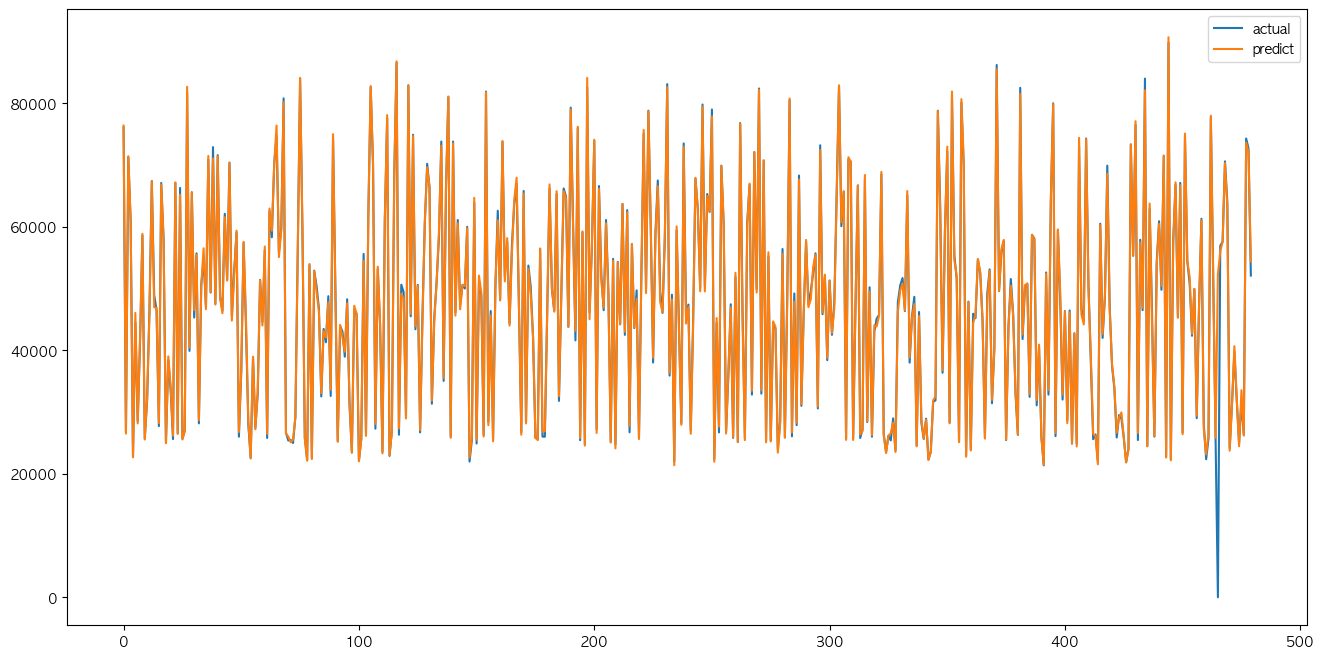

MSE:  6084837.239829632
RMSE:  2466.7462860678706
R2:  0.9802223045279472


In [7]:
# actual price와 predict price를 그래프로 비교
plt.figure(figsize=(16, 8))
plt.plot(df['actual'], label='actual')
plt.plot(df['predict'], label='predict')
plt.legend()
plt.show()

# 모델 accuracy 확인
mse = mean_squared_error(df['actual'], df['predict'])
rmse = np.sqrt(mse)
r2 = r2_score(df['actual'], df['predict'])
print('MSE: ', mse)
print('RMSE: ', rmse)
print('R2: ', r2)



In [8]:
# 오늘 종가, 재무현황, 거래량을 통해 내일 주가를 예측
day = datetime.datetime.now().strftime("%Y%m%d")
week_ago = (datetime.datetime.now() - datetime.timedelta(days=7)).strftime("%Y%m%d")

# 재무현황
today_companyInfo = stock.get_market_fundamental(week_ago, day, predict_target).tail(1)

# 거래량, 종가
today_stockInfo = stock.get_market_ohlcv(week_ago, day, predict_target).tail(1)

# feature: 재무현황, 거래량
today_data = today_companyInfo[['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']]
today_data['거래량'] = today_stockInfo[['거래량']]
today_data['price'] = today_stockInfo['종가']

today_data.head()

,BPS,PER,PBR,EPS,DIV,DPS,거래량,price
날짜,,,,,,,,
2023-09-25,57822,8.61,1.2,8057,2.08,1444,13343349,69400


In [9]:
# 예측
today_pred = lr.predict(today_data)

print("예측값:", today_pred[0][0])

예측값: 69485.85177209927
